In [15]:
# import module

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
from astrodendro import analysis
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as const

In [16]:
cgs_mp = 9.10938291e-28
cgs_me = 9.10938291e-28 
cgs_xmh =  cgs_mp + cgs_me
yHe = 9.7222222e-2 
mu = (1.e0+4.e0*yHe)*cgs_xmh
pc = 3.0856775814671916*10**18 #cm
solar_mass = 1.989*10**33 #g

In [17]:
def get_data(filename):
  d = {}
  with h5py.File(filename, "r") as data:
    data_list = list(data)
    for ls in data_list:
      d[ls] = data[ls][()]
  return d

In [18]:
d = get_data('C:/Users/kotor/StarGen/datasets/data_ppp/cb400.h5')

hx = d['space1']
hy = d['space2']
hz = d['space3']

nH = d['nH']
rho = nH * mu
mass = rho * (hx*pc)**3 / solar_mass

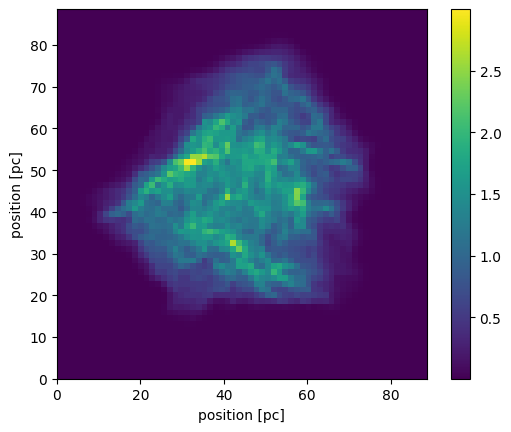

In [19]:
# make int map

int_map_400 = np.sum(mass, axis=0) * hx
extent = [0, hy * mass.shape[1], 0, hz * mass.shape[2]]

fig, ax = plt.subplots()
im = ax.imshow(int_map_400, extent=extent, origin='lower')

#ax.set_title("0.57 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')

cbar = fig.colorbar(im)
#cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')

#plt.savefig("int_map_400")

In [33]:
# compute dendrogram

dendro_400 = Dendrogram.compute(int_map_400, min_value=1, min_delta=0.8, min_npix=20)

In [34]:
# make index

leaf_indices = [i for i, structure in enumerate(dendro_400) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro_400) if structure.is_branch]

leaf_array = [dendro_400[i] for i in leaf_indices]
branch_array = [dendro_400[j] for j in branch_indices]

print('leaf_indices:', leaf_indices)
print('branch_indices:', branch_indices)

leaf_indices: [1, 3, 4]
branch_indices: [0, 2]


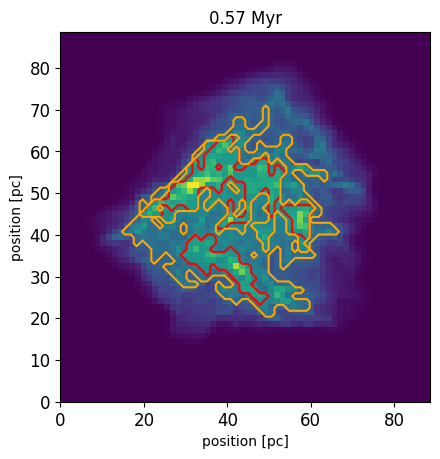

In [35]:
# plot the contour

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(int_map_400, extent=extent, origin='lower')

p = dendro_400.plotter()

for index_leaf in leaf_indices:
    p.plot_contour(ax, extent=extent, structure=index_leaf, colors='red')
for index_branch in branch_indices:
    p.plot_contour(ax, extent=extent, structure=index_branch, colors='orange')

ax.set_title("0.57 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')
plt.tick_params(labelsize=12)

#plt.savefig("dendro_400_contour")